In [1]:
import os
import numpy as np
from tqdm import tqdm

import torch
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from scripts.models import Segmentation_Network_full
from scripts.dataset import H5Dataset

out_dir = './models/clinical_no_TL'

if os.path.exists(out_dir):
    print("path exists")
else:
    os.makedirs(out_dir)


device = 'cuda' if torch.cuda.is_available() else 'cpu'

path exists


In [2]:
train_dataset = H5Dataset('./TL_prepared_data/train/data.hdf5')
test_dataset = H5Dataset('./TL_prepared_data/test/data.hdf5')

batch_size = 16384
epochs = 200


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_dataset), len(test_dataset)

(46028, 43632)

In [3]:
model = Segmentation_Network_full(n_classes=4).float()
summary(model, input_size= (next(iter(train_dataloader))[0][0].shape), device='cpu') 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1          [-1, 32, 8, 8, 8]             288
              ReLU-2          [-1, 32, 8, 8, 8]               0
            Conv3d-3          [-1, 64, 4, 4, 4]          16,448
              ReLU-4          [-1, 64, 4, 4, 4]               0
            Conv3d-5         [-1, 128, 2, 2, 2]          65,664
              ReLU-6         [-1, 128, 2, 2, 2]               0
            Conv3d-7         [-1, 256, 1, 1, 1]         262,400
              ReLU-8         [-1, 256, 1, 1, 1]               0
            Conv3d-9         [-1, 256, 1, 1, 1]          65,792
             ReLU-10         [-1, 256, 1, 1, 1]               0
           Conv3d-11         [-1, 256, 1, 1, 1]          65,792
             ReLU-12         [-1, 256, 1, 1, 1]               0
           Conv3d-13           [-1, 4, 1, 1, 1]           1,028
          Sigmoid-14           [-1, 4, 

In [12]:
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5) 
criterion = F.binary_cross_entropy  
model.to(device).float() 

Segmentation_Network_TL(
  (network): Sequential(
    (0): Conv3d(1, 32, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (1): ReLU()
    (2): Conv3d(32, 64, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (3): ReLU()
    (4): Conv3d(64, 128, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (5): ReLU()
    (6): Conv3d(128, 256, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    (7): ReLU()
    (8): Conv3d(256, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (9): ReLU()
    (10): Conv3d(256, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (11): ReLU()
    (12): Conv3d(256, 4, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (13): Sigmoid()
    (14): Flatten(start_dim=1, end_dim=-1)
  )
)

In [13]:
# All logs will be stored here
with open(f'{out_dir}/logs.csv', 'w') as file:
    file.write('epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy\n')


best_accuracy = 0.0 
best_eval_accuracy = 0.0

for epoch in tqdm(range(epochs)): 
    model.train()
    
    running_loss = 0.0  # used to compute mean values across the whole epoch
    running_acc = 0.0
    
    running_eval_loss = 0.0 
    running_eval_acc = 0.0

    for x,y in iter(train_dataloader): # Train loop
        x = x.to(device)
        y = y.to(device)
        
        opt.zero_grad() 
        
        
        pred = model(x) 
        loss = criterion(pred,y) 
        loss.backward() 
        opt.step() 
        
        running_loss += loss.detach() # detach is used to not store gradients
        
        accuracy = torch.div(torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)),
                             y.size(dim=0)) 
        
        running_acc += accuracy 
            
    running_loss = running_loss/len(train_dataloader) 
    running_acc = running_acc/len(train_dataloader)

    if running_acc > best_accuracy: 
            best_accuracy = running_acc
    
    
    for x,y in iter(test_dataloader): # Test loop
        x = x.to(device)
        y = y.to(device)
        
        model.eval() 
        pred = model(x) 
        loss = criterion(pred,y) 
        
        running_eval_loss += loss.detach()
        
        accuracy = torch.div(torch.sum(torch.argmax(pred, dim=1) == torch.argmax(y, dim=1)),
                             y.size(dim=0)) 
        running_eval_acc += accuracy
    
    running_eval_loss = running_eval_loss/len(test_dataloader)
    running_eval_acc = running_eval_acc/len(test_dataloader)

    if running_eval_acc>= best_eval_accuracy:
            best_eval_accuracy = running_eval_acc
            torch.save(model, f'{out_dir}/best.pt') # Always save the best model

    
    print(f'EPOCH {epoch+1}: Loss: {running_loss}, Accuracy: {running_acc}, Best_accuracy: {best_accuracy}')
    print(f'Val_loss: {running_eval_loss}, Val_accuracy: {running_eval_acc}, Best_val_accuracy: {best_eval_accuracy}')
    print()

    with open(f'{out_dir}/logs.csv', 'a') as file:
        file.write(f'{epoch+1},{running_loss},{running_acc},{best_accuracy},{running_eval_loss},{running_eval_acc},{best_eval_accuracy}\n')
          
            
torch.save(model, f'{out_dir}/last.pt') # Always save the last model alongside with the best one

  1%|▍                                          | 1/100 [00:03<05:11,  3.14s/it]

EPOCH 1: Loss: 0.6768918037414551, Accuracy: 0.24994248151779175, Best_accuracy: 0.24994248151779175
Val_loss: 0.6559163331985474, Val_accuracy: 0.2537834644317627, Best_val_accuracy: 0.2537834644317627



  2%|▊                                          | 2/100 [00:05<04:44,  2.90s/it]

EPOCH 2: Loss: 0.6256232261657715, Accuracy: 0.2498897761106491, Best_accuracy: 0.24994248151779175
Val_loss: 0.5645021796226501, Val_accuracy: 0.2537834644317627, Best_val_accuracy: 0.2537834644317627



  3%|█▎                                         | 3/100 [00:08<04:34,  2.83s/it]

EPOCH 3: Loss: 0.5850868225097656, Accuracy: 0.24984662234783173, Best_accuracy: 0.24994248151779175
Val_loss: 0.5625569820404053, Val_accuracy: 0.2487388551235199, Best_val_accuracy: 0.2537834644317627



  4%|█▋                                         | 4/100 [00:11<04:25,  2.77s/it]

EPOCH 4: Loss: 0.5696094036102295, Accuracy: 0.2502349019050598, Best_accuracy: 0.2502349019050598
Val_loss: 0.5826016664505005, Val_accuracy: 0.2487388551235199, Best_val_accuracy: 0.2537834644317627



  5%|██▏                                        | 5/100 [00:13<04:19,  2.73s/it]

EPOCH 5: Loss: 0.5800063610076904, Accuracy: 0.25028759241104126, Best_accuracy: 0.25028759241104126
Val_loss: 0.5682831406593323, Val_accuracy: 0.2487388551235199, Best_val_accuracy: 0.2537834644317627



  6%|██▌                                        | 6/100 [00:16<04:14,  2.71s/it]

EPOCH 6: Loss: 0.5648512244224548, Accuracy: 0.2947326898574829, Best_accuracy: 0.2947326898574829
Val_loss: 0.5698596835136414, Val_accuracy: 0.2537834644317627, Best_val_accuracy: 0.2537834644317627



  7%|███                                        | 7/100 [00:19<04:10,  2.70s/it]

EPOCH 7: Loss: 0.5693249106407166, Accuracy: 0.249956876039505, Best_accuracy: 0.2947326898574829
Val_loss: 0.5622141361236572, Val_accuracy: 0.2537834644317627, Best_val_accuracy: 0.2537834644317627



  8%|███▍                                       | 8/100 [00:22<04:08,  2.71s/it]

EPOCH 8: Loss: 0.5630464553833008, Accuracy: 0.2500671148300171, Best_accuracy: 0.2947326898574829
Val_loss: 0.5659627914428711, Val_accuracy: 0.2537834644317627, Best_val_accuracy: 0.2537834644317627



  9%|███▊                                       | 9/100 [00:24<04:05,  2.70s/it]

EPOCH 9: Loss: 0.565522313117981, Accuracy: 0.30702388286590576, Best_accuracy: 0.30702388286590576
Val_loss: 0.5619316101074219, Val_accuracy: 0.3775578439235687, Best_val_accuracy: 0.3775578439235687



 10%|████▏                                     | 10/100 [00:27<04:03,  2.71s/it]

EPOCH 10: Loss: 0.561657190322876, Accuracy: 0.34340402483940125, Best_accuracy: 0.34340402483940125
Val_loss: 0.5631684064865112, Val_accuracy: 0.34886106848716736, Best_val_accuracy: 0.3775578439235687



 11%|████▌                                     | 11/100 [00:30<04:00,  2.70s/it]

EPOCH 11: Loss: 0.5622414946556091, Accuracy: 0.37318670749664307, Best_accuracy: 0.37318670749664307
Val_loss: 0.5598553419113159, Val_accuracy: 0.38071703910827637, Best_val_accuracy: 0.38071703910827637



 12%|█████                                     | 12/100 [00:32<03:57,  2.70s/it]

EPOCH 12: Loss: 0.5601401329040527, Accuracy: 0.36406752467155457, Best_accuracy: 0.37318670749664307
Val_loss: 0.559724748134613, Val_accuracy: 0.3540685772895813, Best_val_accuracy: 0.38071703910827637



 13%|█████▍                                    | 13/100 [00:35<03:54,  2.70s/it]

EPOCH 13: Loss: 0.5587249994277954, Accuracy: 0.35618990659713745, Best_accuracy: 0.37318670749664307
Val_loss: 0.5562950372695923, Val_accuracy: 0.3750718832015991, Best_val_accuracy: 0.38071703910827637



 14%|█████▉                                    | 14/100 [00:38<03:53,  2.71s/it]

EPOCH 14: Loss: 0.5552990436553955, Accuracy: 0.37934011220932007, Best_accuracy: 0.37934011220932007
Val_loss: 0.5511556267738342, Val_accuracy: 0.39376765489578247, Best_val_accuracy: 0.39376765489578247



 15%|██████▎                                   | 15/100 [00:40<03:50,  2.72s/it]

EPOCH 15: Loss: 0.5480157732963562, Accuracy: 0.3904104232788086, Best_accuracy: 0.3904104232788086
Val_loss: 0.5390142798423767, Val_accuracy: 0.39720892906188965, Best_val_accuracy: 0.39720892906188965



 16%|██████▋                                   | 16/100 [00:43<03:48,  2.72s/it]

EPOCH 16: Loss: 0.5322592258453369, Accuracy: 0.39337122440338135, Best_accuracy: 0.39337122440338135
Val_loss: 0.5148841142654419, Val_accuracy: 0.39686208963394165, Best_val_accuracy: 0.39720892906188965



 17%|███████▏                                  | 17/100 [00:46<03:45,  2.72s/it]

EPOCH 17: Loss: 0.5071623921394348, Accuracy: 0.39509162306785583, Best_accuracy: 0.39509162306785583
Val_loss: 0.4926384389400482, Val_accuracy: 0.40656885504722595, Best_val_accuracy: 0.40656885504722595



 18%|███████▌                                  | 18/100 [00:49<03:42,  2.72s/it]

EPOCH 18: Loss: 0.4923388361930847, Accuracy: 0.41288912296295166, Best_accuracy: 0.41288912296295166
Val_loss: 0.48732441663742065, Val_accuracy: 0.44653141498565674, Best_val_accuracy: 0.44653141498565674



 19%|███████▉                                  | 19/100 [00:51<03:39,  2.71s/it]

EPOCH 19: Loss: 0.48506683111190796, Accuracy: 0.48392683267593384, Best_accuracy: 0.48392683267593384
Val_loss: 0.4706745147705078, Val_accuracy: 0.5424352884292603, Best_val_accuracy: 0.5424352884292603



 20%|████████▍                                 | 20/100 [00:54<03:37,  2.71s/it]

EPOCH 20: Loss: 0.4662575125694275, Accuracy: 0.5548028945922852, Best_accuracy: 0.5548028945922852
Val_loss: 0.4502914845943451, Val_accuracy: 0.5872801542282104, Best_val_accuracy: 0.5872801542282104



 21%|████████▊                                 | 21/100 [00:57<03:35,  2.72s/it]

EPOCH 21: Loss: 0.4442298114299774, Accuracy: 0.5933808088302612, Best_accuracy: 0.5933808088302612
Val_loss: 0.4202089309692383, Val_accuracy: 0.595550000667572, Best_val_accuracy: 0.595550000667572



 22%|█████████▏                                | 22/100 [01:00<03:32,  2.73s/it]

EPOCH 22: Loss: 0.4120962619781494, Accuracy: 0.6196895837783813, Best_accuracy: 0.6196895837783813
Val_loss: 0.3838347792625427, Val_accuracy: 0.6630054712295532, Best_val_accuracy: 0.6630054712295532



 23%|█████████▋                                | 23/100 [01:02<03:29,  2.72s/it]

EPOCH 23: Loss: 0.3783714175224304, Accuracy: 0.6633379459381104, Best_accuracy: 0.6633379459381104
Val_loss: 0.4406244456768036, Val_accuracy: 0.5737121105194092, Best_val_accuracy: 0.6630054712295532



 24%|██████████                                | 24/100 [01:05<03:27,  2.73s/it]

EPOCH 24: Loss: 0.395449161529541, Accuracy: 0.6250004172325134, Best_accuracy: 0.6633379459381104
Val_loss: 0.3809524476528168, Val_accuracy: 0.6364160776138306, Best_val_accuracy: 0.6630054712295532



 25%|██████████▌                               | 25/100 [01:08<03:24,  2.72s/it]

EPOCH 25: Loss: 0.36427968740463257, Accuracy: 0.6578654050827026, Best_accuracy: 0.6633379459381104
Val_loss: 0.36154383420944214, Val_accuracy: 0.6485321521759033, Best_val_accuracy: 0.6630054712295532



 26%|██████████▉                               | 26/100 [01:10<03:21,  2.72s/it]

EPOCH 26: Loss: 0.35744285583496094, Accuracy: 0.6620078086853027, Best_accuracy: 0.6633379459381104
Val_loss: 0.3579356074333191, Val_accuracy: 0.6649109125137329, Best_val_accuracy: 0.6649109125137329



 27%|███████████▎                              | 27/100 [01:13<03:18,  2.72s/it]

EPOCH 27: Loss: 0.34868323802948, Accuracy: 0.6757879257202148, Best_accuracy: 0.6757879257202148
Val_loss: 0.33938515186309814, Val_accuracy: 0.6839775443077087, Best_val_accuracy: 0.6839775443077087



 28%|███████████▊                              | 28/100 [01:16<03:17,  2.74s/it]

EPOCH 28: Loss: 0.3384402394294739, Accuracy: 0.6851129531860352, Best_accuracy: 0.6851129531860352
Val_loss: 0.32834649085998535, Val_accuracy: 0.6928865313529968, Best_val_accuracy: 0.6928865313529968



 29%|████████████▏                             | 29/100 [01:19<03:15,  2.76s/it]

EPOCH 29: Loss: 0.32777318358421326, Accuracy: 0.6928238272666931, Best_accuracy: 0.6928238272666931
Val_loss: 0.324571818113327, Val_accuracy: 0.696363091468811, Best_val_accuracy: 0.696363091468811



 30%|████████████▌                             | 30/100 [01:21<03:11,  2.74s/it]

EPOCH 30: Loss: 0.3215821385383606, Accuracy: 0.6992506980895996, Best_accuracy: 0.6992506980895996
Val_loss: 0.31674814224243164, Val_accuracy: 0.699978768825531, Best_val_accuracy: 0.699978768825531



 31%|█████████████                             | 31/100 [01:24<03:07,  2.72s/it]

EPOCH 31: Loss: 0.31590694189071655, Accuracy: 0.7037725448608398, Best_accuracy: 0.7037725448608398
Val_loss: 0.31063148379325867, Val_accuracy: 0.7103531360626221, Best_val_accuracy: 0.7103531360626221



 32%|█████████████▍                            | 32/100 [01:27<03:04,  2.71s/it]

EPOCH 32: Loss: 0.31080564856529236, Accuracy: 0.7087669372558594, Best_accuracy: 0.7087669372558594
Val_loss: 0.30955958366394043, Val_accuracy: 0.7120741605758667, Best_val_accuracy: 0.7120741605758667



 33%|█████████████▊                            | 33/100 [01:29<03:00,  2.69s/it]

EPOCH 33: Loss: 0.3065487742424011, Accuracy: 0.7136741876602173, Best_accuracy: 0.7136741876602173
Val_loss: 0.305181086063385, Val_accuracy: 0.7169445753097534, Best_val_accuracy: 0.7169445753097534



 34%|██████████████▎                           | 34/100 [01:32<02:57,  2.70s/it]

EPOCH 34: Loss: 0.30359312891960144, Accuracy: 0.7166216373443604, Best_accuracy: 0.7166216373443604
Val_loss: 0.30197352170944214, Val_accuracy: 0.7179850935935974, Best_val_accuracy: 0.7179850935935974



 35%|██████████████▋                           | 35/100 [01:35<02:55,  2.71s/it]

EPOCH 35: Loss: 0.29996395111083984, Accuracy: 0.719733715057373, Best_accuracy: 0.719733715057373
Val_loss: 0.29888105392456055, Val_accuracy: 0.7223548889160156, Best_val_accuracy: 0.7223548889160156



 36%|███████████████                           | 36/100 [01:38<02:55,  2.73s/it]

EPOCH 36: Loss: 0.2967432141304016, Accuracy: 0.7238789796829224, Best_accuracy: 0.7238789796829224
Val_loss: 0.29611700773239136, Val_accuracy: 0.7253608703613281, Best_val_accuracy: 0.7253608703613281



 37%|███████████████▌                          | 37/100 [01:41<02:55,  2.79s/it]

EPOCH 37: Loss: 0.29384905099868774, Accuracy: 0.7272096872329712, Best_accuracy: 0.7272096872329712
Val_loss: 0.29363521933555603, Val_accuracy: 0.7286620140075684, Best_val_accuracy: 0.7286620140075684



 38%|███████████████▉                          | 38/100 [01:43<02:54,  2.82s/it]

EPOCH 38: Loss: 0.29154080152511597, Accuracy: 0.7292683124542236, Best_accuracy: 0.7292683124542236
Val_loss: 0.2908061742782593, Val_accuracy: 0.7314538955688477, Best_val_accuracy: 0.7314538955688477



 39%|████████████████▍                         | 39/100 [01:46<02:54,  2.86s/it]

EPOCH 39: Loss: 0.28854596614837646, Accuracy: 0.732867419719696, Best_accuracy: 0.732867419719696
Val_loss: 0.2908937931060791, Val_accuracy: 0.7333409190177917, Best_val_accuracy: 0.7333409190177917



 40%|████████████████▊                         | 40/100 [01:49<02:52,  2.88s/it]

EPOCH 40: Loss: 0.28747469186782837, Accuracy: 0.7325410842895508, Best_accuracy: 0.732867419719696
Val_loss: 0.2904840409755707, Val_accuracy: 0.7301812171936035, Best_val_accuracy: 0.7333409190177917



 41%|█████████████████▏                        | 41/100 [01:52<02:52,  2.93s/it]

EPOCH 41: Loss: 0.2851988673210144, Accuracy: 0.7354294657707214, Best_accuracy: 0.7354294657707214
Val_loss: 0.2837211787700653, Val_accuracy: 0.7390748858451843, Best_val_accuracy: 0.7390748858451843



 42%|█████████████████▋                        | 42/100 [01:55<02:50,  2.94s/it]

EPOCH 42: Loss: 0.28177905082702637, Accuracy: 0.7390627264976501, Best_accuracy: 0.7390627264976501
Val_loss: 0.27995097637176514, Val_accuracy: 0.7442727088928223, Best_val_accuracy: 0.7442727088928223



 43%|██████████████████                        | 43/100 [01:58<02:46,  2.91s/it]

EPOCH 43: Loss: 0.2791292667388916, Accuracy: 0.7432950735092163, Best_accuracy: 0.7432950735092163
Val_loss: 0.27728089690208435, Val_accuracy: 0.7471033334732056, Best_val_accuracy: 0.7471033334732056



 44%|██████████████████▍                       | 44/100 [02:01<02:41,  2.88s/it]

EPOCH 44: Loss: 0.275779664516449, Accuracy: 0.7468212842941284, Best_accuracy: 0.7468212842941284
Val_loss: 0.2753291726112366, Val_accuracy: 0.7489761114120483, Best_val_accuracy: 0.7489761114120483



 45%|██████████████████▉                       | 45/100 [02:04<02:36,  2.84s/it]

EPOCH 45: Loss: 0.2728937268257141, Accuracy: 0.7501019835472107, Best_accuracy: 0.7501019835472107
Val_loss: 0.2726306915283203, Val_accuracy: 0.7527371644973755, Best_val_accuracy: 0.7527371644973755



 46%|███████████████████▎                      | 46/100 [02:07<02:31,  2.81s/it]

EPOCH 46: Loss: 0.27019208669662476, Accuracy: 0.7540559768676758, Best_accuracy: 0.7540559768676758
Val_loss: 0.26936042308807373, Val_accuracy: 0.756954550743103, Best_val_accuracy: 0.756954550743103



 47%|███████████████████▋                      | 47/100 [02:09<02:27,  2.79s/it]

EPOCH 47: Loss: 0.26756972074508667, Accuracy: 0.7575711607933044, Best_accuracy: 0.7575711607933044
Val_loss: 0.26668351888656616, Val_accuracy: 0.7595095634460449, Best_val_accuracy: 0.7595095634460449



 48%|████████████████████▏                     | 48/100 [02:12<02:24,  2.77s/it]

EPOCH 48: Loss: 0.2637103497982025, Accuracy: 0.7616297602653503, Best_accuracy: 0.7616297602653503
Val_loss: 0.26126813888549805, Val_accuracy: 0.7673973441123962, Best_val_accuracy: 0.7673973441123962



 49%|████████████████████▌                     | 49/100 [02:15<02:21,  2.78s/it]

EPOCH 49: Loss: 0.25986093282699585, Accuracy: 0.7678701877593994, Best_accuracy: 0.7678701877593994
Val_loss: 0.25819700956344604, Val_accuracy: 0.7724450826644897, Best_val_accuracy: 0.7724450826644897



 50%|█████████████████████                     | 50/100 [02:18<02:20,  2.80s/it]

EPOCH 50: Loss: 0.2549557089805603, Accuracy: 0.7733919024467468, Best_accuracy: 0.7733919024467468
Val_loss: 0.25356972217559814, Val_accuracy: 0.7778860926628113, Best_val_accuracy: 0.7778860926628113



 51%|█████████████████████▍                    | 51/100 [02:21<02:19,  2.84s/it]

EPOCH 51: Loss: 0.250852108001709, Accuracy: 0.778458833694458, Best_accuracy: 0.778458833694458
Val_loss: 0.25049734115600586, Val_accuracy: 0.7820295095443726, Best_val_accuracy: 0.7820295095443726



 52%|█████████████████████▊                    | 52/100 [02:23<02:16,  2.84s/it]

EPOCH 52: Loss: 0.24696078896522522, Accuracy: 0.7822401523590088, Best_accuracy: 0.7822401523590088
Val_loss: 0.24377548694610596, Val_accuracy: 0.7904364466667175, Best_val_accuracy: 0.7904364466667175



 53%|██████████████████████▎                   | 53/100 [02:26<02:13,  2.84s/it]

EPOCH 53: Loss: 0.24335390329360962, Accuracy: 0.7869124412536621, Best_accuracy: 0.7869124412536621
Val_loss: 0.23967526853084564, Val_accuracy: 0.7936521768569946, Best_val_accuracy: 0.7936521768569946



 54%|██████████████████████▋                   | 54/100 [02:29<02:09,  2.81s/it]

EPOCH 54: Loss: 0.2383677214384079, Accuracy: 0.793122410774231, Best_accuracy: 0.793122410774231
Val_loss: 0.23700396716594696, Val_accuracy: 0.7966892123222351, Best_val_accuracy: 0.7966892123222351



 55%|███████████████████████                   | 55/100 [02:32<02:05,  2.78s/it]

EPOCH 55: Loss: 0.23536044359207153, Accuracy: 0.795928955078125, Best_accuracy: 0.795928955078125
Val_loss: 0.22922246158123016, Val_accuracy: 0.806524932384491, Best_val_accuracy: 0.806524932384491



 56%|███████████████████████▌                  | 56/100 [02:34<02:01,  2.76s/it]

EPOCH 56: Loss: 0.2288062423467636, Accuracy: 0.8048369884490967, Best_accuracy: 0.8048369884490967
Val_loss: 0.22664600610733032, Val_accuracy: 0.8102644681930542, Best_val_accuracy: 0.8102644681930542



 57%|███████████████████████▉                  | 57/100 [02:37<01:58,  2.76s/it]

EPOCH 57: Loss: 0.22564738988876343, Accuracy: 0.80727219581604, Best_accuracy: 0.80727219581604
Val_loss: 0.2415165901184082, Val_accuracy: 0.7904245853424072, Best_val_accuracy: 0.8102644681930542



 58%|████████████████████████▎                 | 58/100 [02:40<01:58,  2.81s/it]

EPOCH 58: Loss: 0.22745460271835327, Accuracy: 0.8052529096603394, Best_accuracy: 0.80727219581604
Val_loss: 0.22904768586158752, Val_accuracy: 0.8068392276763916, Best_val_accuracy: 0.8102644681930542



 59%|████████████████████████▊                 | 59/100 [02:43<01:55,  2.82s/it]

EPOCH 59: Loss: 0.2227928340435028, Accuracy: 0.8113663196563721, Best_accuracy: 0.8113663196563721
Val_loss: 0.2253381311893463, Val_accuracy: 0.8114023208618164, Best_val_accuracy: 0.8114023208618164



 60%|█████████████████████████▏                | 60/100 [02:46<01:53,  2.83s/it]

EPOCH 60: Loss: 0.21592891216278076, Accuracy: 0.8185960650444031, Best_accuracy: 0.8185960650444031
Val_loss: 0.2165875881910324, Val_accuracy: 0.8197084665298462, Best_val_accuracy: 0.8197084665298462



 61%|█████████████████████████▌                | 61/100 [02:49<01:50,  2.82s/it]

EPOCH 61: Loss: 0.21047255396842957, Accuracy: 0.8234504461288452, Best_accuracy: 0.8234504461288452
Val_loss: 0.2109420746564865, Val_accuracy: 0.8258157968521118, Best_val_accuracy: 0.8258157968521118



 62%|██████████████████████████                | 62/100 [02:51<01:47,  2.82s/it]

EPOCH 62: Loss: 0.20698681473731995, Accuracy: 0.8272470831871033, Best_accuracy: 0.8272470831871033
Val_loss: 0.208779439330101, Val_accuracy: 0.8288190364837646, Best_val_accuracy: 0.8288190364837646



 63%|██████████████████████████▍               | 63/100 [02:54<01:44,  2.81s/it]

EPOCH 63: Loss: 0.20302125811576843, Accuracy: 0.8324558138847351, Best_accuracy: 0.8324558138847351
Val_loss: 0.2022339403629303, Val_accuracy: 0.8347851037979126, Best_val_accuracy: 0.8347851037979126



 64%|██████████████████████████▉               | 64/100 [02:57<01:40,  2.80s/it]

EPOCH 64: Loss: 0.19853973388671875, Accuracy: 0.8371020555496216, Best_accuracy: 0.8371020555496216
Val_loss: 0.1967230886220932, Val_accuracy: 0.8410912752151489, Best_val_accuracy: 0.8410912752151489



 65%|███████████████████████████▎              | 65/100 [03:00<01:38,  2.80s/it]

EPOCH 65: Loss: 0.1954077184200287, Accuracy: 0.8397994041442871, Best_accuracy: 0.8397994041442871
Val_loss: 0.19433581829071045, Val_accuracy: 0.8430613279342651, Best_val_accuracy: 0.8430613279342651



 66%|███████████████████████████▋              | 66/100 [03:03<01:35,  2.80s/it]

EPOCH 66: Loss: 0.19232577085494995, Accuracy: 0.8427046537399292, Best_accuracy: 0.8427046537399292
Val_loss: 0.20167943835258484, Val_accuracy: 0.8353350162506104, Best_val_accuracy: 0.8430613279342651



 67%|████████████████████████████▏             | 67/100 [03:05<01:32,  2.80s/it]

EPOCH 67: Loss: 0.20015239715576172, Accuracy: 0.8341536521911621, Best_accuracy: 0.8427046537399292
Val_loss: 0.1958983987569809, Val_accuracy: 0.8437134623527527, Best_val_accuracy: 0.8437134623527527



 68%|████████████████████████████▌             | 68/100 [03:08<01:29,  2.79s/it]

EPOCH 68: Loss: 0.19722718000411987, Accuracy: 0.837408721446991, Best_accuracy: 0.8427046537399292
Val_loss: 0.20612037181854248, Val_accuracy: 0.8351496458053589, Best_val_accuracy: 0.8437134623527527



 69%|████████████████████████████▉             | 69/100 [03:11<01:26,  2.79s/it]

EPOCH 69: Loss: 0.20387785136699677, Accuracy: 0.8318288326263428, Best_accuracy: 0.8427046537399292
Val_loss: 0.19289618730545044, Val_accuracy: 0.8464655876159668, Best_val_accuracy: 0.8464655876159668



 70%|█████████████████████████████▍            | 70/100 [03:14<01:23,  2.78s/it]

EPOCH 70: Loss: 0.19359956681728363, Accuracy: 0.8427691459655762, Best_accuracy: 0.8427691459655762
Val_loss: 0.18450850248336792, Val_accuracy: 0.8539809584617615, Best_val_accuracy: 0.8539809584617615



 71%|█████████████████████████████▊            | 71/100 [03:16<01:20,  2.78s/it]

EPOCH 71: Loss: 0.18295399844646454, Accuracy: 0.8520722389221191, Best_accuracy: 0.8520722389221191
Val_loss: 0.18524137139320374, Val_accuracy: 0.8531209230422974, Best_val_accuracy: 0.8539809584617615



 72%|██████████████████████████████▏           | 72/100 [03:19<01:17,  2.77s/it]

EPOCH 72: Loss: 0.18096911907196045, Accuracy: 0.8545476794242859, Best_accuracy: 0.8545476794242859
Val_loss: 0.17918306589126587, Val_accuracy: 0.8580152988433838, Best_val_accuracy: 0.8580152988433838



 73%|██████████████████████████████▋           | 73/100 [03:22<01:14,  2.77s/it]

EPOCH 73: Loss: 0.17554336786270142, Accuracy: 0.858569860458374, Best_accuracy: 0.858569860458374
Val_loss: 0.17293700575828552, Val_accuracy: 0.864520788192749, Best_val_accuracy: 0.864520788192749



 74%|███████████████████████████████           | 74/100 [03:25<01:11,  2.76s/it]

EPOCH 74: Loss: 0.17095735669136047, Accuracy: 0.8630870580673218, Best_accuracy: 0.8630870580673218
Val_loss: 0.17240941524505615, Val_accuracy: 0.865666389465332, Best_val_accuracy: 0.865666389465332



 75%|███████████████████████████████▌          | 75/100 [03:27<01:08,  2.75s/it]

EPOCH 75: Loss: 0.16774243116378784, Accuracy: 0.86631840467453, Best_accuracy: 0.86631840467453
Val_loss: 0.16667461395263672, Val_accuracy: 0.8692598342895508, Best_val_accuracy: 0.8692598342895508



 76%|███████████████████████████████▉          | 76/100 [03:30<01:06,  2.78s/it]

EPOCH 76: Loss: 0.1637221872806549, Accuracy: 0.8691744208335876, Best_accuracy: 0.8691744208335876
Val_loss: 0.1697189062833786, Val_accuracy: 0.8659701347351074, Best_val_accuracy: 0.8692598342895508



 77%|████████████████████████████████▎         | 77/100 [03:33<01:03,  2.77s/it]

EPOCH 77: Loss: 0.16267697513103485, Accuracy: 0.871373176574707, Best_accuracy: 0.871373176574707
Val_loss: 0.16173194348812103, Val_accuracy: 0.8738231062889099, Best_val_accuracy: 0.8738231062889099



 78%|████████████████████████████████▊         | 78/100 [03:36<01:00,  2.77s/it]

EPOCH 78: Loss: 0.15863317251205444, Accuracy: 0.8749217987060547, Best_accuracy: 0.8749217987060547
Val_loss: 0.16051553189754486, Val_accuracy: 0.8752998113632202, Best_val_accuracy: 0.8752998113632202



 79%|█████████████████████████████████▏        | 79/100 [03:39<00:57,  2.76s/it]

EPOCH 79: Loss: 0.16411910951137543, Accuracy: 0.8684682250022888, Best_accuracy: 0.8749217987060547
Val_loss: 0.17242929339408875, Val_accuracy: 0.8649560809135437, Best_val_accuracy: 0.8752998113632202



 80%|█████████████████████████████████▌        | 80/100 [03:41<00:54,  2.75s/it]

EPOCH 80: Loss: 0.15823784470558167, Accuracy: 0.8745571374893188, Best_accuracy: 0.8749217987060547
Val_loss: 0.165941521525383, Val_accuracy: 0.8705728054046631, Best_val_accuracy: 0.8752998113632202



 81%|██████████████████████████████████        | 81/100 [03:44<00:52,  2.75s/it]

EPOCH 81: Loss: 0.16393783688545227, Accuracy: 0.8677295446395874, Best_accuracy: 0.8749217987060547
Val_loss: 0.15271517634391785, Val_accuracy: 0.8820328712463379, Best_val_accuracy: 0.8820328712463379



 82%|██████████████████████████████████▍       | 82/100 [03:47<00:49,  2.75s/it]

EPOCH 82: Loss: 0.1582951694726944, Accuracy: 0.8737995028495789, Best_accuracy: 0.8749217987060547
Val_loss: 0.15551665425300598, Val_accuracy: 0.8776528835296631, Best_val_accuracy: 0.8820328712463379



 83%|██████████████████████████████████▊       | 83/100 [03:49<00:46,  2.75s/it]

EPOCH 83: Loss: 0.15478681027889252, Accuracy: 0.877724289894104, Best_accuracy: 0.877724289894104
Val_loss: 0.15156249701976776, Val_accuracy: 0.882476806640625, Best_val_accuracy: 0.882476806640625



 84%|███████████████████████████████████▎      | 84/100 [03:52<00:44,  2.75s/it]

EPOCH 84: Loss: 0.15045353770256042, Accuracy: 0.8813620805740356, Best_accuracy: 0.8813620805740356
Val_loss: 0.15118779242038727, Val_accuracy: 0.883206844329834, Best_val_accuracy: 0.883206844329834



 85%|███████████████████████████████████▋      | 85/100 [03:55<00:41,  2.74s/it]

EPOCH 85: Loss: 0.1499495804309845, Accuracy: 0.8811103701591492, Best_accuracy: 0.8813620805740356
Val_loss: 0.15031248331069946, Val_accuracy: 0.8836971521377563, Best_val_accuracy: 0.8836971521377563



 86%|████████████████████████████████████      | 86/100 [03:58<00:38,  2.74s/it]

EPOCH 86: Loss: 0.14945214986801147, Accuracy: 0.8810436129570007, Best_accuracy: 0.8813620805740356
Val_loss: 0.14985381066799164, Val_accuracy: 0.8836905360221863, Best_val_accuracy: 0.8836971521377563



 87%|████████████████████████████████████▌     | 87/100 [04:00<00:35,  2.74s/it]

EPOCH 87: Loss: 0.14599484205245972, Accuracy: 0.8846248984336853, Best_accuracy: 0.8846248984336853
Val_loss: 0.15269801020622253, Val_accuracy: 0.8815697431564331, Best_val_accuracy: 0.8836971521377563



 88%|████████████████████████████████████▉     | 88/100 [04:03<00:32,  2.74s/it]

EPOCH 88: Loss: 0.14595365524291992, Accuracy: 0.8846776485443115, Best_accuracy: 0.8846776485443115
Val_loss: 0.15374892950057983, Val_accuracy: 0.8813301920890808, Best_val_accuracy: 0.8836971521377563



 89%|█████████████████████████████████████▍    | 89/100 [04:06<00:30,  2.73s/it]

EPOCH 89: Loss: 0.14349275827407837, Accuracy: 0.8869611620903015, Best_accuracy: 0.8869611620903015
Val_loss: 0.1520576924085617, Val_accuracy: 0.8830360770225525, Best_val_accuracy: 0.8836971521377563



 90%|█████████████████████████████████████▊    | 90/100 [04:09<00:27,  2.73s/it]

EPOCH 90: Loss: 0.1409824788570404, Accuracy: 0.8882956504821777, Best_accuracy: 0.8882956504821777
Val_loss: 0.14790791273117065, Val_accuracy: 0.8855478763580322, Best_val_accuracy: 0.8855478763580322



 91%|██████████████████████████████████████▏   | 91/100 [04:11<00:24,  2.74s/it]

EPOCH 91: Loss: 0.13790449500083923, Accuracy: 0.8929799795150757, Best_accuracy: 0.8929799795150757
Val_loss: 0.14619287848472595, Val_accuracy: 0.8870043754577637, Best_val_accuracy: 0.8870043754577637



 92%|██████████████████████████████████████▋   | 92/100 [04:14<00:21,  2.74s/it]

EPOCH 92: Loss: 0.13520877063274384, Accuracy: 0.8952533602714539, Best_accuracy: 0.8952533602714539
Val_loss: 0.1456851363182068, Val_accuracy: 0.8885048627853394, Best_val_accuracy: 0.8885048627853394



 93%|███████████████████████████████████████   | 93/100 [04:17<00:19,  2.74s/it]

EPOCH 93: Loss: 0.13417480885982513, Accuracy: 0.8953955173492432, Best_accuracy: 0.8953955173492432
Val_loss: 0.14408588409423828, Val_accuracy: 0.8892402052879333, Best_val_accuracy: 0.8892402052879333



 94%|███████████████████████████████████████▍  | 94/100 [04:20<00:16,  2.74s/it]

EPOCH 94: Loss: 0.13333289325237274, Accuracy: 0.895321249961853, Best_accuracy: 0.8953955173492432
Val_loss: 0.13626067340373993, Val_accuracy: 0.8957114219665527, Best_val_accuracy: 0.8957114219665527



 95%|███████████████████████████████████████▉  | 95/100 [04:22<00:13,  2.76s/it]

EPOCH 95: Loss: 0.1306390017271042, Accuracy: 0.8981478214263916, Best_accuracy: 0.8981478214263916
Val_loss: 0.13372556865215302, Val_accuracy: 0.8974727988243103, Best_val_accuracy: 0.8974727988243103



 96%|████████████████████████████████████████▎ | 96/100 [04:25<00:10,  2.75s/it]

EPOCH 96: Loss: 0.13038967549800873, Accuracy: 0.8986968994140625, Best_accuracy: 0.8986968994140625
Val_loss: 0.13549186289310455, Val_accuracy: 0.8952668905258179, Best_val_accuracy: 0.8974727988243103



 97%|████████████████████████████████████████▋ | 97/100 [04:28<00:08,  2.74s/it]

EPOCH 97: Loss: 0.1297069638967514, Accuracy: 0.8987408876419067, Best_accuracy: 0.8987408876419067
Val_loss: 0.13531863689422607, Val_accuracy: 0.8951935172080994, Best_val_accuracy: 0.8974727988243103



 98%|█████████████████████████████████████████▏| 98/100 [04:31<00:05,  2.74s/it]

EPOCH 98: Loss: 0.13172972202301025, Accuracy: 0.8964523077011108, Best_accuracy: 0.8987408876419067
Val_loss: 0.13151264190673828, Val_accuracy: 0.899526834487915, Best_val_accuracy: 0.899526834487915



 99%|█████████████████████████████████████████▌| 99/100 [04:33<00:02,  2.74s/it]

EPOCH 99: Loss: 0.1273309588432312, Accuracy: 0.9006361961364746, Best_accuracy: 0.9006361961364746
Val_loss: 0.1300548017024994, Val_accuracy: 0.9010850787162781, Best_val_accuracy: 0.9010850787162781



100%|█████████████████████████████████████████| 100/100 [04:36<00:00,  2.77s/it]

EPOCH 100: Loss: 0.12744837999343872, Accuracy: 0.9008908271789551, Best_accuracy: 0.9008908271789551
Val_loss: 0.14007622003555298, Val_accuracy: 0.8932157754898071, Best_val_accuracy: 0.9010850787162781



In [14]:
import pandas as pd

df = pd.read_csv(f'{out_dir}/logs.csv')
df

,epoch,loss,accuracy,best_accuracy,val_loss,val_accuracy,best_val_accuracy
0,1,0.516235,0.591762,0.591762,0.440943,0.703596,0.703596
1,2,0.315022,0.785306,0.785306,0.228081,0.853760,0.853760
2,3,0.219331,0.854434,0.854434,0.211029,0.860620,0.860620
3,4,0.175108,0.886988,0.886988,0.159744,0.898582,0.898582
4,5,0.149536,0.905201,0.905201,0.147604,0.907476,0.907476
...,...,...,...,...,...,...,...
95,96,0.002926,0.998506,0.999173,0.241117,0.942393,0.944587
96,97,0.006546,0.996612,0.999173,0.205221,0.943156,0.944587
97,98,0.005639,0.996960,0.999173,0.211348,0.942238,0.944587
98,99,0.003663,0.998346,0.999173,0.223679,0.937211,0.944587


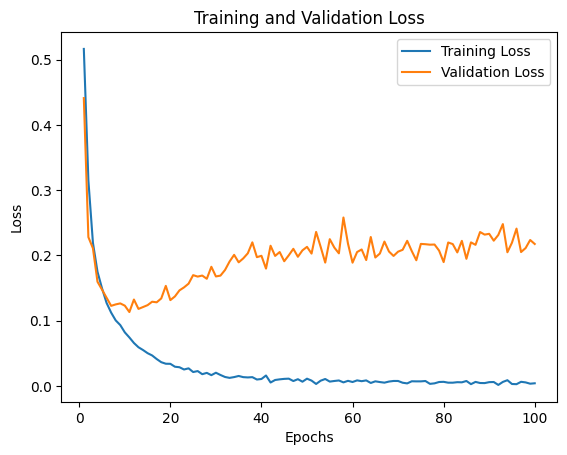

In [15]:
import matplotlib.pyplot as plt

plt.plot(df.epoch, df.loss, label='Training Loss')
plt.plot(df.epoch, df.val_loss, label='Validation Loss')
 
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

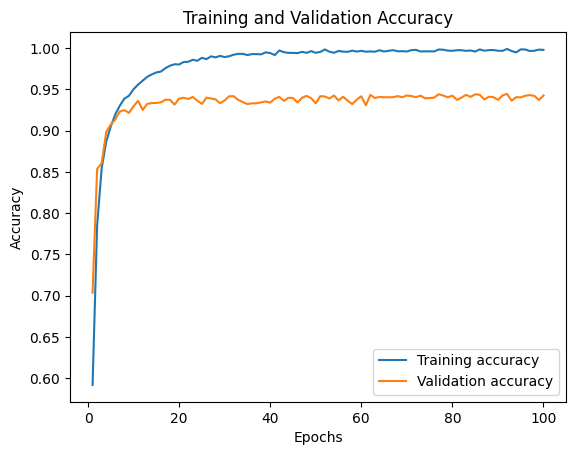

In [16]:
plt.plot(df.epoch, df.accuracy, label='Training accuracy')
plt.plot(df.epoch, df.val_accuracy, label='Validation accuracy')
 
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

In [37]:
preds = []
labels = []

model = torch.load(f'{out_dir}/best.pt') 
model.to('cpu')
model.eval() 
for x,y in iter(test_dataloader): 
    pred = model(x) 
    preds.append(pred.detach())

    labels.append(y)


preds = np.concatenate(preds, axis=0)
labels = np.concatenate(labels, axis=0)

preds = np.argmax(preds, axis=1)
labels = np.argmax(labels, axis=1)

In [41]:
from sklearn.metrics import classification_report

report = classification_report(y_true=labels, y_pred=preds)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     10908
           1       0.96      0.88      0.92     10908
           2       0.91      0.89      0.90     10908
           3       0.82      0.93      0.87     10908

    accuracy                           0.90     43632
   macro avg       0.90      0.90      0.90     43632
weighted avg       0.90      0.90      0.90     43632



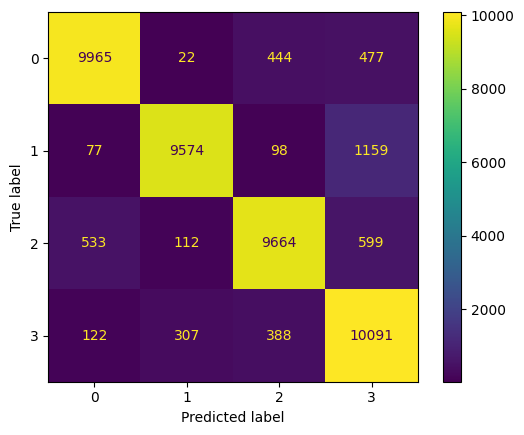

In [65]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


cm = confusion_matrix(y_true=labels,
                      y_pred=preds)


plt.Figure()
disp = ConfusionMatrixDisplay(cm,)

disp.plot(values_format='')
#['lv', 'epi', 'rv', 'base']